# Bayesian linear regression

The model in prototyped with TensorFlow Probability and inferecne is performed with variational Bayes by stochastic gradient descent. 
Details on [Wikipedia](https://en.wikipedia.org/wiki/Bayesian_linear_regression).

Some codes are borrowed from 
[Brendan Hasz](https://brendanhasz.github.io/2018/12/03/tfp-regression.html) and 
[TensorFlow Probability examples](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_PCA.ipynb)

Author: Yuanhua Huang

Date: 24/11/2019

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

## Generate data

In [2]:
# Settings
np.random.seed(3)

D = 4   #number of dimensions
N = 100 #number of datapoints to generate

# Generate data
b_true = np.random.randn(1)
w_true = np.random.randn(D, 1)
x = np.random.randn(N, D)
noise = 0.2 * np.random.randn(N,1)
y = np.dot(x, w_true) + b_true + noise

# Cast to float32
x = x.astype('float32')
y = y.astype('float32')

## Define the model

In [3]:
class BayesianLinearRegression():
    def __init__(self, d, name=None):
        self.w_loc = tf.Variable(tf.random.normal([d, 1]), name='w_loc')
        self.w_std = tf.Variable(tf.random.normal([d, 1]), name='w_std')
        self.b_loc = tf.Variable(tf.random.normal([1]), name='b_loc')
        self.b_std = tf.Variable(tf.random.normal([1]), name='b_std')
        self.s_alpha = tf.Variable(tf.exp(tf.random.normal([1])), name='s_alpha')
        self.s_beta = tf.Variable(tf.exp(tf.random.normal([1])), name='s_beta')
    
    @property
    def weight(self):
        """Variational posterior for the weight"""
        return tfd.Normal(self.w_loc, tf.exp(self.w_std))
    
    @property
    def bias(self):
        """Variational posterior for the bias"""
        return tfd.Normal(self.b_loc, tf.exp(self.b_std))

    @property
    def std(self):
        """Variational posterior for the noise standard deviation"""
        return tfd.InverseGamma(tf.exp(self.s_alpha), tf.exp(self.s_beta))
    
    @property
    def losses(self):
        """Sum of KL divergences between posteriors and priors"""
        prior = tfd.Normal(0, 1)
        return (tf.reduce_sum(tfd.kl_divergence(self.weight, prior)) +
                tf.reduce_sum(tfd.kl_divergence(self.bias, prior)))
    
    def predict(self, x, sampling=False):
        """Predict p(y|x), based on current parameters"""
        sample = lambda x: x.sample() if sampling else x.mean()
        loc = tf.matmul(x, sample(self.weight)) + sample(self.bias)
        std = tf.sqrt(sample(self.std))
        return tfd.Normal(loc, std)
    
    def fit(self, xtrain, ytrain, num_steps=100, optimizer=None,
            learn_rate=0.05):
        """Fit the model's parameters"""
        if optimizer is None:
            optimizer = tf.optimizers.Adam(learning_rate=learn_rate)
            
        loss_fn = lambda: (self.losses - 
                           tf.reduce_sum(self.predict(xtrain).log_prob(ytrain)))
        
        losses = tfp.math.minimize(loss_fn, 
                                   num_steps=num_steps, 
                                   optimizer=optimizer)
        return losses

## Fit the model

In [4]:
model = BayesianLinearRegression(D)

In [5]:
model.w_loc

<tf.Variable 'w_loc:0' shape=(4, 1) dtype=float32, numpy=
array([[ 0.37953132],
       [-0.5863257 ],
       [-0.7822008 ],
       [-1.0127012 ]], dtype=float32)>

In [6]:
losses = model.fit(x, y, num_steps=500)

Text(0.5, 0, 'Interations')

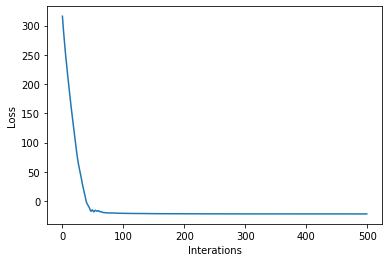

In [7]:
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Interations")

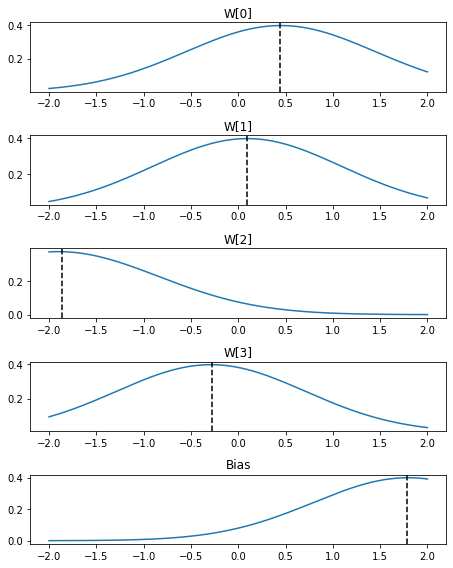

In [8]:
fig = plt.figure(figsize=(6.4, 8))
v = np.linspace(-2, 2, 400)

# Plot weight posteriors
probs = model.weight.prob(v*np.ones([D, 1]))
for i in range(D):
    plt.subplot(D+1, 1, i+1)
    plt.plot(v, probs[i, :])
    plt.axvline(x=w_true[i], linestyle='--', color='k')
    plt.title('W[{}]'.format(i))
    
# Plot Bias posterior
plt.subplot(D+1, 1, D+1)
plt.plot(v, model.bias.prob(v))
plt.axvline(x=b_true, linestyle='--', color='k')
plt.title('Bias')

plt.tight_layout()
plt.show()